In [18]:
import glob
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pyreadr
import icd10
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Configuration
harmonized_fname = 'harmonized_open_target.csv'

In [25]:
# Load the ICD-10 dataset
df_icd = pd.read_csv("data/DiagAll_Eng.csv")
df_icd['ShortDescription'] = df_icd['ShortDescription'].replace(
    "Dementia in Alzheimer\'s disease", "Dementia"
)
df_icd = df_icd.drop_duplicates(subset=["ShortDescription"])  # Ensure unique descriptions
icd_dict = dict(zip(df_icd["ShortDescription"], df_icd["Code"]))
icd_dict = {k.replace("\"", ""): v for k, v in icd_dict.items()}
icd_dict['Dementia in Alzheimer\'s disease'] = 'F00'
icd_descriptions = list(icd_dict.keys())
icd_codes = list(icd_dict.values())

In [26]:
icd_dict

{'Healthy': '000',
 'Cholera': 'A00',
 'Typhoid and paratyphoid fevers': 'A01',
 'Other salmonella infections': 'A02',
 'Shigellosis': 'A03',
 'Other bacterial intestinal infections': 'A04',
 'Other bacterial foodborne intoxications, not elsewhere classified': 'A05',
 'Amebiasis': 'A06',
 'Other protozoal intestinal diseases': 'A07',
 'Viral and other specified intestinal infections': 'A08',
 'Infectious gastroenteritis and colitis, unspecified': 'A09',
 'Respiratory tuberculosis': 'A15',
 'Respiratory tuberculosis, not confirmed': 'A16',
 'Tuberculosis of nervous system': 'A17',
 'Tuberculosis of other organs': 'A18',
 'Miliary tuberculosis': 'A19',
 'Plague': 'A20',
 'Tularemia': 'A21',
 'Anthrax': 'A22',
 'Brucellosis': 'A23',
 'Glanders and melioidosis': 'A24',
 'Rat-bite fevers': 'A25',
 'Erysipeloid': 'A26',
 'Leptospirosis': 'A27',
 'Other zoonotic bacterial diseases, not elsewhere classified': 'A28',
 "Leprosy [Hansen's disease]": 'A30',
 'Infection due to other mycobacteria': 

In [27]:
# open_target_df = pd.read_csv('../CTD/data/open_targets/cor_matrix_95_nolit.csv')
# open_target_df = pd.read_csv('../CTD/data/target_disease/cor_matrix_99.csv.csv')
open_target_df = pd.read_csv('data/open_targets_25_09/dis_dis_nolit_25_09.csv')
open_target_df.index = open_target_df.columns
open_target_df
# for col in open_target_df.columns:
#     if 'ementia' in col:
#         print(col)

,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger cutaneous syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,26S proteasome non-ATPase regulatory subunit 7 amount,...,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease,хомосексуа́лност
15q overgrowth syndrome,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17,20-lyase deficiency, isolated",0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined complete",0.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
2-3 finger cutaneous syndactyly,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.064783,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zebra body myopathy,0.0,0.0,0.0,0.0,0.064783,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.02714,0.0,0.0,0.0
"zinc deficiency, transient neonatal",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.027140,0.00000,0.0,0.0,0.0
zygodactyly type 3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
Åland Islands eye disease,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0


In [28]:
# # Add one umbrella for all dementia related diseases
# # Identify columns/rows related to 'dementia' or 'alzheimer' (case-insensitive)
# disease_mask = open_target_df.columns.str.contains('dementia', case=False, regex=True)  # |alzheimer
# selected_diseases = open_target_df.columns[disease_mask]

# # Compute the mean correlation of the selected diseases with all diseases
# merged_row = open_target_df.loc[selected_diseases].mean()
# merged_col = open_target_df[selected_diseases].mean(axis=1)

# # Add the new row and column to the DataFrame
# open_target_df["Dementia in Alzheimer's disease"] = merged_col
# open_target_df.loc["Dementia in Alzheimer's disease"] = list(merged_row) + [0.0]  # correlation with itself
# open_target_df

# Map OpenTargets disease names to ICD10 codes

In [29]:
# Precompute disease embeddings with retry strategy and caching
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import os
import time
import pickle

diseases = open_target_df.columns

# Define cache directories
model_cache_dir = "./models/pubmedbert-base-embeddings"
embeddings_cache_file = "./models/disease_embeddings_cache.pkl"

def load_model_with_retry(model_name, cache_dir, max_retries=5, initial_delay=2):
    """
    Load sentence transformer model with exponential backoff retry strategy.
    
    Args:
        model_name: Name of the model on HuggingFace
        cache_dir: Local directory to cache the model
        max_retries: Maximum number of retry attempts
        initial_delay: Initial delay in seconds (doubles with each retry)
    
    Returns:
        Loaded model or raises exception after max retries
    """
    delay = initial_delay
    
    for attempt in range(max_retries):
        try:
            if os.path.exists(cache_dir):
                print(f'Loading model from local cache: {cache_dir}')
                return SentenceTransformer(cache_dir)
            else:
                print(f'Attempt {attempt + 1}/{max_retries}: Downloading model from HuggingFace...')
                model = SentenceTransformer(model_name)
                # Save to local cache for future use
                os.makedirs(cache_dir, exist_ok=True)
                model.save(cache_dir)
                print(f'✓ Model saved to {cache_dir}')
                return model
                
        except Exception as e:
            if attempt < max_retries - 1:
                print(f'⚠️ Attempt {attempt + 1} failed: {str(e)[:100]}')
                print(f'   Retrying in {delay} seconds...')
                time.sleep(delay)
                delay *= 2  # Exponential backoff
            else:
                raise Exception(f"Failed to load model after {max_retries} attempts: {e}")

# Check if embeddings are already cached
if os.path.exists(embeddings_cache_file):
    print(f'Loading embeddings from cache: {embeddings_cache_file}')
    with open(embeddings_cache_file, 'rb') as f:
        cache_data = pickle.load(f)
        icd_embeddings = cache_data['icd_embeddings']
        disease_embeddings = cache_data['disease_embeddings']
    print(f'✓ Loaded {len(disease_embeddings)} disease embeddings and {len(icd_embeddings)} ICD embeddings from cache')
else:
    print('No cached embeddings found. Computing embeddings...')
    
    # Load model with retry strategy
    print('Loading sentence transformer model with retry strategy...')
    model = load_model_with_retry("NeuML/pubmedbert-base-embeddings", model_cache_dir)
    
    print('Creating ICD10 embeddings...')
    icd_embeddings = model.encode(icd_descriptions, convert_to_tensor=False)
    
    print('Precomputing disease embeddings...')
    disease_embeddings = {disease: model.encode(disease, convert_to_tensor=False) for disease in tqdm(diseases)}
    
    # Save embeddings to cache
    os.makedirs(os.path.dirname(embeddings_cache_file), exist_ok=True)
    with open(embeddings_cache_file, 'wb') as f:
        pickle.dump({
            'icd_embeddings': icd_embeddings,
            'disease_embeddings': disease_embeddings
        }, f)
    print(f'✓ Embeddings saved to cache: {embeddings_cache_file}')
    print('✓ Successfully loaded model and created embeddings')


Loading embeddings from cache: ./models/disease_embeddings_cache.pkl
✓ Loaded 14417 disease embeddings and 1076 ICD embeddings from cache


In [30]:
def map_diseases(disease_name_1, disease_embedding, icd_dict, icd_descriptions, icd_codes, icd_embeddings):
    """
    Map a disease name to the closest ICD-10 description using semantic embeddings.
    
    Args:
        disease_name_1: The disease name to map
        disease_embedding: Pre-computed embedding for the disease
        icd_dict: Dictionary mapping ICD descriptions to codes
        icd_descriptions: List of ICD-10 descriptions
        icd_codes: List of ICD-10 codes
        icd_embeddings: Pre-computed embeddings for ICD descriptions
    
    Returns:
        Matched ICD-10 description or "UNKNOWN"
    """
    # Check for exact match first
    if disease_name_1 in icd_dict:
        return disease_name_1
    
    # Use semantic similarity via embeddings
    disease_embedding_tensor = torch.tensor(disease_embedding)
    icd_embeddings_tensor = torch.tensor(icd_embeddings)
    
    similarities = util.pytorch_cos_sim(disease_embedding_tensor, icd_embeddings_tensor)[0]
    best_match_idx = similarities.argmax().item()
    
    # Return match if similarity > 0.5, otherwise UNKNOWN
    return icd_descriptions[best_match_idx] if similarities[best_match_idx] > 0.5 else "UNKNOWN"

# Map diseases to ICD-10 codes with progress tracking
diseases_mapping = {}
print("Mapping diseases using semantic embeddings...")

for disease in tqdm(diseases, desc="Mapping disease names to ICD-10"):
    diseases_mapping[disease] = map_diseases(
        disease, 
        disease_embeddings[disease],
        icd_dict, 
        icd_descriptions, 
        icd_codes, 
        icd_embeddings
    )

# Print sample mappings
print("\nSample mappings (first 50):")
for disease, icd in list(diseases_mapping.items())[:50]:
    print(f"{disease}: {icd}")

# Print mapping statistics
total_diseases = len(diseases_mapping)
mapped_diseases = sum(1 for v in diseases_mapping.values() if v != "UNKNOWN")
unknown_diseases = total_diseases - mapped_diseases

print(f"\n📊 Mapping Statistics:")
print(f"   Total diseases: {total_diseases}")
print(f"   Successfully mapped: {mapped_diseases} ({mapped_diseases/total_diseases*100:.1f}%)")
print(f"   Unknown/unmapped: {unknown_diseases} ({unknown_diseases/total_diseases*100:.1f}%)")

Mapping diseases using semantic embeddings...


Mapping disease names to ICD-10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14417/14417 [00:04<00:00, 3229.69it/s]


Sample mappings (first 50):
15q overgrowth syndrome: UNKNOWN
17,20-lyase deficiency, isolated: UNKNOWN
17-alpha-hydroxylase/17,20-lyase deficiency, combined complete: UNKNOWN
17-alpha-hydroxylase/17,20-lyase deficiency, combined partial: UNKNOWN
2-3 finger cutaneous syndactyly: Acquired deformities of fingers and toes
2-3 toe syndactyly: Acquired deformities of fingers and toes
2-aminoadipic 2-oxoadipic aciduria: UNKNOWN
2-hydroxyglutaric aciduria: UNKNOWN
2-methylbutyryl-CoA dehydrogenase deficiency: Disorders of branched-chain amino-acid metabolism and fatty-acid metabolism
26S proteasome non-ATPase regulatory subunit 7 amount: UNKNOWN
3-4 toe syndactyly: Acquired deformities of fingers and toes
3-M syndrome: UNKNOWN
3-Methylglutaric aciduria: Disorders of branched-chain amino-acid metabolism and fatty-acid metabolism
3-hydroxy-3-methylglutaric aciduria: UNKNOWN
3-hydroxy-3-methylglutaryl-CoA synthase deficiency: UNKNOWN
3-hydroxyacyl-CoA dehydrogenase deficiency: UNKNOWN
3-hydroxyi

In [31]:
# Filter columns based on diseases_mapping values that are not 'UNKNOWN'
print("Filtering columns based on valid diseases (not 'UNKNOWN')...")
valid_diseases = {k: v for k, v in diseases_mapping.items() if v != 'UNKNOWN'}

# Ensure only valid keys are used for filtering
valid_keys = set(valid_diseases.keys()) & set(open_target_df.columns)
print(f"Selecting {len(valid_keys)} valid diseases from the matrix...")
filtered_open_target_df = open_target_df.loc[list(valid_keys), list(valid_keys)]

# Rename only the columns and rows that exist in the mapping
rename_mapping = {k: v for k, v in valid_diseases.items() if k in filtered_open_target_df.columns}
print("Renaming rows and columns according to diseases_mapping...")
filtered_open_target_df = filtered_open_target_df.rename(index=rename_mapping, columns=rename_mapping)
print(f"Matrix shape after renaming: {filtered_open_target_df.shape}")

# Check for duplicated column/row names after renaming
duplicated_columns = filtered_open_target_df.columns[filtered_open_target_df.columns.duplicated()].unique()

if len(duplicated_columns) > 0:
    print(f"Found {len(duplicated_columns)} duplicate disease names. Merging duplicates using max correlation...")
    
    # Optimized approach: Process all duplicates at once using groupby
    # For correlation matrices, we take the max value as the representative correlation
    # (since we want to preserve the strongest relationship)
    
    # Group by column names and take max for each group (preserves strongest correlations)
    filtered_open_target_df = filtered_open_target_df.groupby(level=0, axis=1).max()
    # Group by row names and take max for each group
    filtered_open_target_df = filtered_open_target_df.groupby(level=0, axis=0).max()
    
    print(f"Duplicates merged. New matrix shape: {filtered_open_target_df.shape}")
else:
    print("No duplicate disease names found.")

# Display final transformed matrix shape
print(f"Transformation completed. Final matrix shape: {filtered_open_target_df.shape}")

Filtering columns based on valid diseases (not 'UNKNOWN')...
Selecting 8503 valid diseases from the matrix...
Renaming rows and columns according to diseases_mapping...
Matrix shape after renaming: (8503, 8503)
Found 631 duplicate disease names. Merging duplicates using max correlation...


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_3366/347787877.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  filtered_open_target_df = filtered_open_target_df.groupby(level=0, axis=1).max()


Duplicates merged. New matrix shape: (781, 781)
Transformation completed. Final matrix shape: (781, 781)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_3366/347787877.py:29: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  filtered_open_target_df = filtered_open_target_df.groupby(level=0, axis=0).max()


In [32]:
for disease, icd in list(diseases_mapping.items()):
    if ('ementia' in disease) or ('lzheimer' in disease):
        print(f"{disease}: {icd}")

AIDS dementia: Dementia
Alzheimer disease: Alzheimer's disease
Alzheimer disease 18: Alzheimer's disease
Alzheimer disease 3: Alzheimer's disease
Alzheimer disease type 1: Alzheimer's disease
Alzheimer's disease neuropathologic change: Alzheimer's disease
Dementia: Dementia
Frontotemporal dementia: Dementia
Lewy body dementia: Dementia in Alzheimer's disease
age of onset of Alzheimer disease: Alzheimer's disease
amyotrophic lateral sclerosis 26 with or without frontotemporal dementia: Vascular dementia
amyotrophic lateral sclerosis-parkinsonism-dementia complex: Parkinson's disease
behavioral variant of frontotemporal dementia: Dementia
dementia: Dementia
early-onset autosomal dominant Alzheimer disease: Alzheimer's disease
familial Alzheimer disease: Alzheimer's disease
family history of Alzheimer’s disease: Alzheimer's disease
frontotemporal dementia: Dementia
frontotemporal dementia and/or amyotrophic lateral sclerosis: Dementia in Alzheimer's disease
frontotemporal dementia and/or 

In [34]:
harmonized_open_targets = filtered_open_target_df.copy() # List of relevant rows/columns

# Generate matrix with ICD10 codes
# Validate and filter out diseases that cannot be mapped to ICD codes
valid_cols = [col for col in harmonized_open_targets.columns if col in icd_dict]
if len(valid_cols) != len(harmonized_open_targets.columns):
    unmapped_count = len(harmonized_open_targets.columns) - len(valid_cols)
    print(f"Filtering {unmapped_count} unmapped diseases")
    unmapped = [col for col in harmonized_open_targets.columns if col not in icd_dict]
    print(f"Unmapped diseases: {unmapped[:10]}")  # Show first 10
    harmonized_open_targets = harmonized_open_targets.loc[valid_cols, valid_cols]

# Verify no duplicates exist after filtering
print(f"Checking for duplicates after filtering...")
print(f"  Duplicate columns: {harmonized_open_targets.columns.duplicated().sum()}")
print(f"  Duplicate rows: {harmonized_open_targets.index.duplicated().sum()}")

# Remove any remaining duplicates (shouldn't happen but safety check)
if harmonized_open_targets.columns.duplicated().any():
    print("  Warning: Found duplicate columns, removing...")
    harmonized_open_targets = harmonized_open_targets.loc[:, ~harmonized_open_targets.columns.duplicated(keep='first')]
if harmonized_open_targets.index.duplicated().any():
    print("  Warning: Found duplicate rows, removing...")
    harmonized_open_targets = harmonized_open_targets.loc[~harmonized_open_targets.index.duplicated(keep='first'), :]

# Safely rename Dementia to standardized name if it exists
# if 'Dementia' in harmonized_open_targets.index:
#     harmonized_open_targets.rename(index={'Dementia': 'Dementia in Alzheimer\'s disease'}, inplace=True)
# if 'Dementia' in harmonized_open_targets.columns:
#     harmonized_open_targets.rename(columns={'Dementia': 'Dementia in Alzheimer\'s disease'}, inplace=True)

# Define target labels for dementia-related conditions
target_labels = ['Dementia', 'Dementia in Alzheimer\'s disease', 'Vascular dementia', 'Alzheimer\'s disease']

# Filter target_labels to only include those present in the dataframe
available_targets = [label for label in target_labels if label in harmonized_open_targets.index]
print(f"Using {len(available_targets)} target labels: {available_targets}")

if len(available_targets) > 0:
    # Apply max operation across specified rows and columns to create umbrella category
    row_or = harmonized_open_targets.loc[available_targets].max(axis=0).astype(float)
    
    # Update the 'Dementia in Alzheimer's disease' row and column
    # Use .values to avoid index alignment issues
    harmonized_open_targets.loc['Dementia in Alzheimer\'s disease', :] = row_or.values
    harmonized_open_targets.loc[:, 'Dementia in Alzheimer\'s disease'] = row_or.values
    
    print(f"✓ Updated 'Dementia in Alzheimer's disease' umbrella category")
else:
    print("Warning: No target labels found in the dataframe")

print(f"Final matrix shape: {harmonized_open_targets.shape}")

Checking for duplicates after filtering...
  Duplicate columns: 0
  Duplicate rows: 0
Using 4 target labels: ['Dementia', "Dementia in Alzheimer's disease", 'Vascular dementia', "Alzheimer's disease"]
✓ Updated 'Dementia in Alzheimer's disease' umbrella category
Final matrix shape: (781, 781)


In [35]:
# Write to file
harmonized_open_targets.to_csv(harmonized_fname, index=False)
# Now map to ICD codes
harmonized_open_targets.columns = [icd_dict[x] for x in harmonized_open_targets.columns]
harmonized_open_targets.to_csv(harmonized_fname.replace('.csv', '_icd.csv'), index=False)

Percentage of zeros: 25.47%


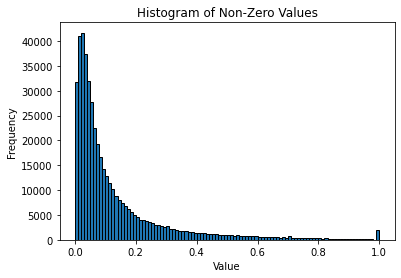

In [36]:
# Flatten DataFrame values to 1D array
all_values = harmonized_open_targets.values.flatten()

# Count zeros and non-zeros
total_values = len(all_values)
zero_count = np.count_nonzero(all_values == 0)
non_zero_values = all_values[all_values != 0]

# Calculate percentage of zeros
zero_percentage = (zero_count / total_values) * 100
print(f"Percentage of zeros: {zero_percentage:.2f}%")

# Plot histogram of non-zero values
plt.hist(non_zero_values, bins=100, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Values')
plt.show()

# Merge with hospital data

In [37]:
diag_df = pd.read_csv('data/Diagnosis_global_10years.csv')  # Read diagnosis metadata  DiagAll_Eng.csv
diag_df = diag_df[diag_df['age_id'] < 9].iloc[:1080, :]
# Add an 'ID' column to diag_df starting from 0 up to the number of rows in diag_df
diag_df['ID'] = range(0, len(diag_df))
diag_df.loc[:, 'English description'] = [icd10.find(x[0]).description if icd10.find(x[0]) else x[1] for x in diag_df[['icd_code', 'descr']].values ]
diag_df.loc[:, 'icd_global'] = diag_df['icd_global'].str.replace('__', '-')
diag_df

,Unnamed: 0,diagnose_id,icd_code,descr,postion,age_id,age_range,icd_global,ID,English description
0,1,1,A00,Cholera,1,1,0-9,A00-0-9,0,Cholera
1,2,2,A01,Typhus abdominalis und Paratyphus,2,1,0-9,A01-0-9,1,Typhoid and paratyphoid fevers
2,3,3,A02,Sonstige Salmonelleninfektionen,3,1,0-9,A02-0-9,2,Other salmonella infections
3,4,4,A03,Shigellose [Bakterielle Ruhr],4,1,0-9,A03-0-9,3,Shigellosis
4,5,5,A04,Sonstige bakterielle Darminfektionen,5,1,0-9,A04-0-9,4,Other bacterial intestinal infections
...,...,...,...,...,...,...,...,...,...,...
1075,1076,1070,N95,Klimakterische Störungen,1076,1,0-9,N95-0-9,1075,Menopausal and other perimenopausal disorders
1076,1077,1071,N96,"Neigung zu habituellem Abort, Infertilität, Un...",1077,1,0-9,N96-0-9,1076,Recurrent pregnancy loss
1077,1078,1072,N97,Sterilität der Frau,1078,1,0-9,N97-0-9,1077,Female infertility
1078,1079,1073,N98,Komplikationen im Zusammenhang mit künstlicher...,1079,1,0-9,N98-0-9,1078,Complications associated with artificial ferti...


In [38]:
open_target_df = pd.read_csv(harmonized_fname.replace('.csv', '_icd.csv'))
open_target_df.index = open_target_df.columns
# open_target_df = (open_target_df > 0).astype(int)
display(open_target_df)

,K61,J85,F55,L83,L70,M20,D59,D60,A42,I33,...,E50,D51,E55,L80,E86,A37,A66,A95,B02,B46
K61,0.000000,0.011867,0.000000,0.034571,0.000708,0.040960,0.029877,0.040501,0.0,0.000000,...,0.000000,0.000000,0.008416,0.000000,0.069013,0.000000,0.000000,0.000000,0.000000,0.000000
J85,0.011867,0.000000,0.012443,0.000000,0.010078,0.002227,0.039541,0.015942,0.0,0.001213,...,0.000000,0.000000,0.010264,0.008450,0.026849,0.000000,0.000000,0.000000,0.000000,0.000000
F55,0.000000,0.012443,0.065077,0.017480,0.017125,0.037936,0.036725,0.038907,0.0,0.017228,...,0.252556,0.006519,0.077631,0.026632,0.097505,0.052038,0.018754,0.000000,0.040151,0.000000
L83,0.034571,0.000000,0.017480,0.778373,0.034363,0.409152,0.052774,0.056094,0.0,0.026293,...,0.020032,0.019439,0.300988,0.262245,0.053223,0.016738,0.001013,0.000000,0.007920,0.019236
L70,0.000708,0.010078,0.017125,0.034363,0.591786,0.281017,0.102203,0.154679,0.0,0.051674,...,0.032872,0.043092,0.044951,0.068475,0.043073,0.430102,0.293065,0.151231,0.767027,0.148819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A37,0.000000,0.000000,0.052038,0.016738,0.430102,0.152416,0.031613,0.056738,0.0,0.000000,...,0.012949,0.002920,0.000000,0.084066,0.020872,0.000000,0.040077,0.000000,0.486198,0.000000
A66,0.000000,0.000000,0.018754,0.001013,0.293065,0.080280,0.046430,0.108377,0.0,0.000000,...,0.004300,0.051944,0.010266,0.216185,0.013560,0.040077,0.000000,0.102793,0.281916,0.134725
A95,0.000000,0.000000,0.000000,0.000000,0.151231,0.382275,0.050428,0.067545,0.0,0.000000,...,0.000000,0.053638,0.014714,0.000000,0.006296,0.000000,0.102793,0.000000,0.000000,0.271935
B02,0.000000,0.000000,0.040151,0.007920,0.767027,0.264659,0.170241,0.386265,0.0,0.021133,...,0.042052,0.000000,0.014184,0.032072,0.022704,0.486198,0.281916,0.000000,0.057649,0.000000


In [39]:
import time
import random
from Bio import Entrez
from urllib.error import HTTPError

Entrez.email = "x@y.com"#"your_email@example.com"

# Function to search PubMed with retries
def search_pubmed_with_retry(disease1, disease2, max_results=20_000, retries=5, delay=0.5):
    query = f"{disease1} AND {disease2}"
    
    for attempt in range(retries):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
            record = Entrez.read(handle)
            handle.close()
            num_articles = len(record["IdList"])
#             print(f"🔍 {disease1}: Found {num_articles} articles.")
            return num_articles
        
        except HTTPError as e:
            print(f"⚠️ HTTPError for query '{query}': {e}. Retrying in {delay} seconds...")
        except Exception as e:
            print(f"⚠️ Unexpected error for query '{query}': {e}. Retrying in {delay} seconds...")
        
        time.sleep(delay)
        delay *= 2  # Exponential backoff
    
    print(f"❌ Failed to fetch results for '{query}' after {retries} retries.")
    
pubmed_cache = {}

def get_pubmed_count_cached(disease1, disease2):
    key = (disease1.lower(), disease2.lower())
    if key not in pubmed_cache:
        pubmed_cache[key] = search_pubmed_with_retry(disease1, disease2)
    return pubmed_cache[key]


In [44]:
df

icd_code,A00,A02,A03,A04,A06,A07,A08,A09,A15,A19,...,N84,N85,N86,N87,N92,N93,N94,N95,N96,N97
icd_code,,,,,,,,,,,,,,,,,,,,,
A00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
A02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
A03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
A04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.582114,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
A06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.519958,0.0,0.0
N94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
N95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Secondary malignant neoplasm of respiratory and digestive organs
Other pleural conditions
Other psychoactive substance related disorders
Nasal polyp
Other bacterial intestinal infections
Other respiratory disorders
Rheumatic mitral valve diseases
Rubella [German measles]
Other interstitial pulmonary diseases
Osteitis deformans [Paget's disease of bone]
Osteoporosis with current pathological fracture
Other epidermal thickening
 not elsewhere classified"
Nystagmus and other irregular eye movements
Rubella [German measles]
Other stimulant related disorders
Other and unspecified disorders of Eustachian tube
Rheumatic mitral valve diseases
Malignant neoplasm of trachea
Nontraumatic subarachnoid hemorrhage
Other respiratory disorders
Other disorders of psychological development
Other pulmonary heart diseases


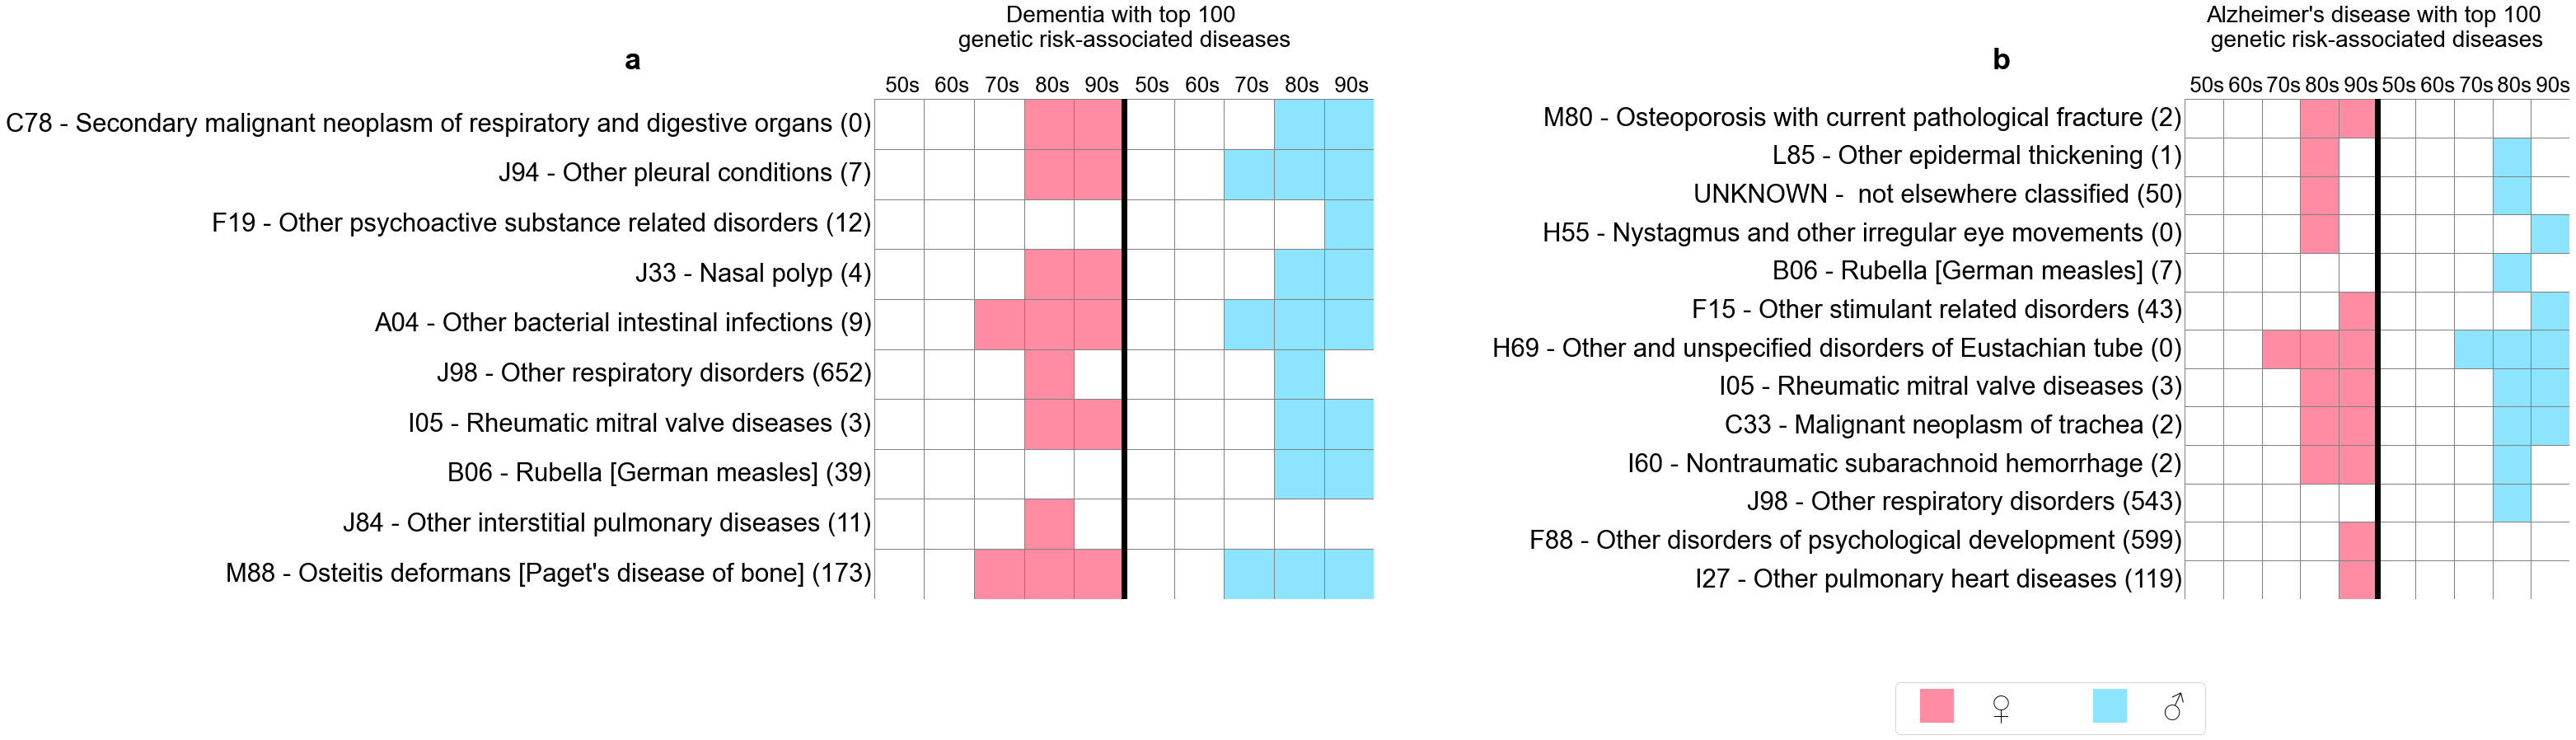

In [45]:
dementia_codes = {'F00': 'Dementia', #'Dementia in Alzheimer\'s disease'
                  'F01': 'Vascular dementia',
                  'F02': 'Dementia in other diseases classified elsewhere',
                  'F03': 'Unspecified dementia',
                  'G30': 'Alzheimer\'s disease'}

with open(harmonized_fname, 'r') as f:
    disease_names = f.readline().strip().split(',')
rds_files = glob.glob("data/dementia_age_groups/*.rds")

disease_name_icd10_dict = dict(zip(disease_names, open_target_df.columns))

for TOP_K in [100]:
    fig, axes = plt.subplots(1, 2, figsize=(50, 13))  # 2 columns, 1 row
    fig.subplots_adjust(wspace=0.3)  # increase this value for more space
    for i, code in enumerate(['F00', 'G30']):
        # Check if code exists in open_target_df
        if code not in open_target_df.index:
            print(f"Warning: Code {code} not found in open_target_df, skipping...")
            continue
            
        df_out = pd.DataFrame(columns=['Graph', 'ICD10', 'Correlated disease', 'Num correlated diseases'])
        ind = 0
        for f in rds_files:
            result = pyreadr.read_r(f) # also works for RData
            # result is a dictionary where keys are the name of objects and the values python
            df = result[None] # extract the pandas data frame 
            # dfs[gender].columns = [str(col) for col in df.columns]
            df.fillna(0, inplace=True)
            df.columns = diag_df['icd_code']
            df.index = diag_df['icd_code']
            df = df.loc[df.index.isin(open_target_df.index), df.columns.isin(open_target_df.columns)]
            
            # Merge F01, F02, F03 into F00 by taking max (row + column wise)
            merge_codes = ['F00', 'F01', 'F02', 'F03']

            # ensure all exist
            existing = [c for c in merge_codes if c in df.index and c in df.columns]

            # compute merged row/column
            merged_row = df.loc[existing].max(axis=0)
            merged_col = df[existing].max(axis=1)

            # assign to F00
            df.loc['F00'] = merged_row
            df['F00'] = merged_col

            # drop the merged-out nodes
#             df = df.drop(index=[c for c in existing if c != 'F00'],
#                          columns=[c for c in existing if c != 'F00'])

            
            if code not in df.index:
                print(f"Warning: Code {code} not found in {f}, skipping...")
                continue
                
            row1 = open_target_df.loc[code]
            row2 = df.loc[code]

            # Get the indices of the TOP_K largest elements in row1
            top_k = min(TOP_K, len(row1))  # Handle case where there are fewer than TOP_K diseases
            top_indices = np.argpartition(row1.values, -top_k)[-top_k:]
            # Sort those indices by the actual values (optional, to have sorted results)
            top_indices = top_indices[np.argsort(-row1.values[top_indices])]
            top_disease_names = np.array(disease_names)[top_indices]

            # Extract subsets
            row1_subset = row1.values[top_indices]
            row2_subset = row2.values[top_indices]
            try:
                correlated_diseases = top_disease_names[np.nonzero(row2_subset)[0]]
            except TypeError as e:
                correlated_diseases = [] 

            df_out.loc[ind] = [f.split('/')[-1].split('.')[0].replace('All_OR_', ''), code, correlated_diseases, len(correlated_diseases)]
            ind+=1

        if len(df_out) == 0:
            print(f"Warning: No data for code {code}, skipping plot...")
            continue

        gr_dis_dict = dict(zip(df_out['Graph'], df_out['Correlated disease']))

        dis_gr_dict = dict()
        for graph, dis in gr_dis_dict.items():
            for d in dis:
                if d in dis_gr_dict.keys():
                    dis_gr_dict[d].append(graph)
                else:
                    dis_gr_dict[d] = [graph]
                    
        if len(dis_gr_dict) == 0:
            print(f"Warning: No diseases found for code {code}, skipping plot...")
            continue
            
        dis_gr_df = pd.DataFrame({(k, ','.join(v)) for k, v in dis_gr_dict.items()}, columns=['Disease', 'Detected in'])
        for gr in sorted(gr_dis_dict.keys()):
            dis_gr_df.loc[:, gr.replace('_Age_', ' ') + '0s'] = dis_gr_df['Detected in'].apply(lambda x: 1 if gr in x else 0)
        dis_gr_df.rename(columns={'Disease': dementia_codes[code]}, inplace=True)

        dis_gr_df = dis_gr_df.drop(columns=['Detected in'])
        dis_gr_df.set_index(dementia_codes[code], inplace=True)
        for col in dis_gr_df.columns:
            if 'Male' in col:
                dis_gr_df.loc[:, col] = dis_gr_df[col].apply(lambda x: (x + 1) if x else x)  # For painting in different color

        # Modify column and index labels to replace "Female" and "Male" with symbols
        dis_gr_df.columns = [la.replace("Female", "").replace("Male", "") for la in dis_gr_df.columns]
        
        # Compute PubMed article counts and modify index labels
        new_index = []
        for disease in dis_gr_df.index:
            print(disease)
            cleaned_disease = disease.replace("\"", "")
            pubmed_count = get_pubmed_count_cached(dementia_codes[code], cleaned_disease)
            # Safely get ICD code, use 'UNKNOWN' if not found
            icd_code = icd_dict.get(cleaned_disease, 'UNKNOWN')
            new_lab = f"{icd_code} - {cleaned_disease} ({pubmed_count})".replace("\"", "")
            new_index.append(new_lab)

        dis_gr_df.index = new_index

        # Set font to Arial
        plt.rcParams["font.family"] = "Arial"

        # Custom colormap
        male_female_color = ["#ff8ca3", "#8ce4ff"]
        cmap = sns.color_palette(["white"] + male_female_color)

        # Plot heatmap
        ax = sns.heatmap(dis_gr_df, cmap=cmap, cbar=False, linewidths=0.5, linecolor='gray', square=True, ax=axes[i])

        # Move x-axis labels to the top
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')

        # Make x-axis labels horizontal and increase font sizes
        ax.tick_params(axis='x', labelrotation=0, labelsize=26)
        ax.tick_params(axis='y', labelsize=31)
        ax.tick_params(axis='both', which='both', length=0) # Remove tick marks
        ax.set_title(f'{dementia_codes[code]} with top {TOP_K} \ngenetic risk-associated diseases\n', size=28)
        
        mid = len(dis_gr_df.columns) // 2
        ax.axvline(x=mid, color='black', linewidth=7)

        # Add subplot letter labels (a, b, c...)
        label = chr(97 + i)  # 'a' for 0, 'b' for 1, etc.
        ax.text(-0.5, 1.05, f'{label}', transform=ax.transAxes,
                fontsize=36, fontweight='bold', va='bottom', ha='left')
                
    labels = ['♀ ', '♂ ']

    # Create custom legend handles
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label=labels[i],
               markerfacecolor=male_female_color[i], markersize=42)
        for i in range(2)
    ]

    # Create the legend at the bottom
    plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(-0.35, -0.3),
               ncol=2, frameon=True, fontsize=36)

    # Adjust layout and save to PDF
    plt.tight_layout()
    pos1 = axes[0].get_position()
    pos2 = axes[1].get_position()

    new_y0 = pos1.y0 + pos1.height - pos2.height
    axes[1].set_position([pos2.x0, new_y0, pos2.width, pos2.height])

    plt.savefig(f"dementia_heatmaps_{TOP_K}.pdf", dpi=300, format='pdf', bbox_inches='tight')
    plt.show()